In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras as ks
import numpy as np
from tensorflow.keras import Input
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix
import gc

In [2]:
train = pd.read_csv('../data/split_data/train_stats.csv', index_col=0)
test = pd.read_csv('../data/split_data/test_stats.csv', index_col=0)
train.head()

,tension_index_int,mode_int,std_int,mean_int,var_int,pnn50_int,RMSSD_int,ivr_int,vpr_int,papr_int,...,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
0,38.040113,795.642857,69.377642,823.428571,8.425460,55.0,70.359079,0.000605,0.000005,0.000180,...,0,0,0,0,0,0,0,0,0,0
1,35.472331,853.238095,69.195100,824.190476,8.395523,50.0,69.460780,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
2,35.472331,853.238095,69.072770,824.380952,8.378744,55.0,70.608781,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
3,35.472331,853.238095,69.829725,823.238095,8.482324,55.0,71.369461,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0
4,35.472331,853.238095,72.383634,819.238095,8.835482,60.0,74.592225,0.000605,0.000005,0.000167,...,0,0,0,0,0,0,0,0,0,0


In [3]:
zero_train = train.copy()
zero_test = test.copy()

for column in zero_train.iloc[:, -21:].columns:
    zero_train = zero_train.loc[zero_train[column] == 0]
    zero_test = zero_test.loc[zero_test[column] == 0]

one_train = train.drop(index=zero_train.index)
zero_train = zero_train.sample(one_train.shape[0] // 2)


zero_train_r_r = zero_train.iloc[:, -42:-21]
test_r_r = test.iloc[:, -42:-21]

In [40]:
model = ks.Sequential([
    ks.layers.Input(shape=(20, 1)),

    ks.layers.Conv1D( filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Conv1D( filters=32, kernel_size=5, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.MaxPooling1D(2),
    ks.layers.BatchNormalization(),
    ks.layers.Dropout(0.2),

    ks.layers.Flatten(),
    ks.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    ks.layers.Dense(1),
    tf.keras.layers.LeakyReLU(alpha=0.2)
                        ])

In [41]:
model.compile(optimizer=ks.optimizers.Adam(learning_rate=0.01), loss='mape', metrics='mae')

In [42]:
history = model.fit(x=zero_train_r_r.loc[:, 'r-r-0': 'r-r-19'].values.reshape((-1, 20, 1)),
                    y=zero_train_r_r.loc[:, 'r-r-20'],
                    batch_size=32,
                    epochs=100,
                    shuffle=True,
                    verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 16ms/step - loss: 99.4636 - mae: 704.9362
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 95.2478 - mae: 690.8015
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 83.6084 - mae: 614

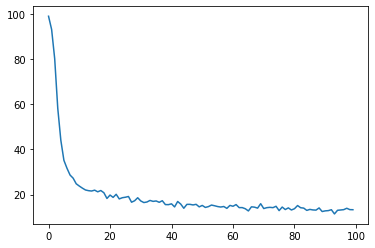

In [43]:
plt.plot(history.epoch, history.history['loss'])

In [44]:
pred_r_r = model.predict(zero_train_r_r.loc[:, 'r-r-0': 'r-r-19'].values.reshape((-1, 20, 1)))
pred_r_r = pred_r_r.reshape(-1)

In [53]:
true_train_r_r = zero_train_r_r.loc[:, 'r-r-20'].values

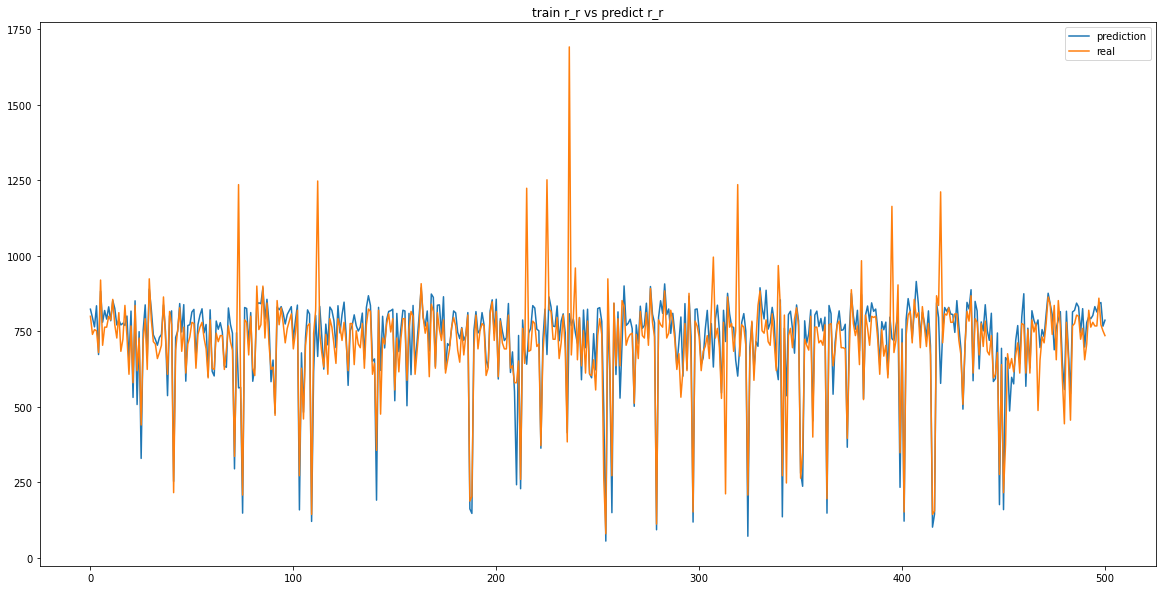

In [54]:
plt.figure(figsize=(20, 10))
plt.title('train r_r vs predict r_r')
plt.plot(np.arange(0, len(pred_r_r)),
         pred_r_r)
plt.plot(np.arange(0, len(pred_r_r)),
         true_train_r_r)
plt.legend(['prediction', 'real'])
plt.show()

In [57]:
test_predict_r_r = model.predict(test_r_r.values[:, :-1].reshape(-1, 20, 1)).reshape(-1)
true_test_r_r = test_r_r.values[:, -1]

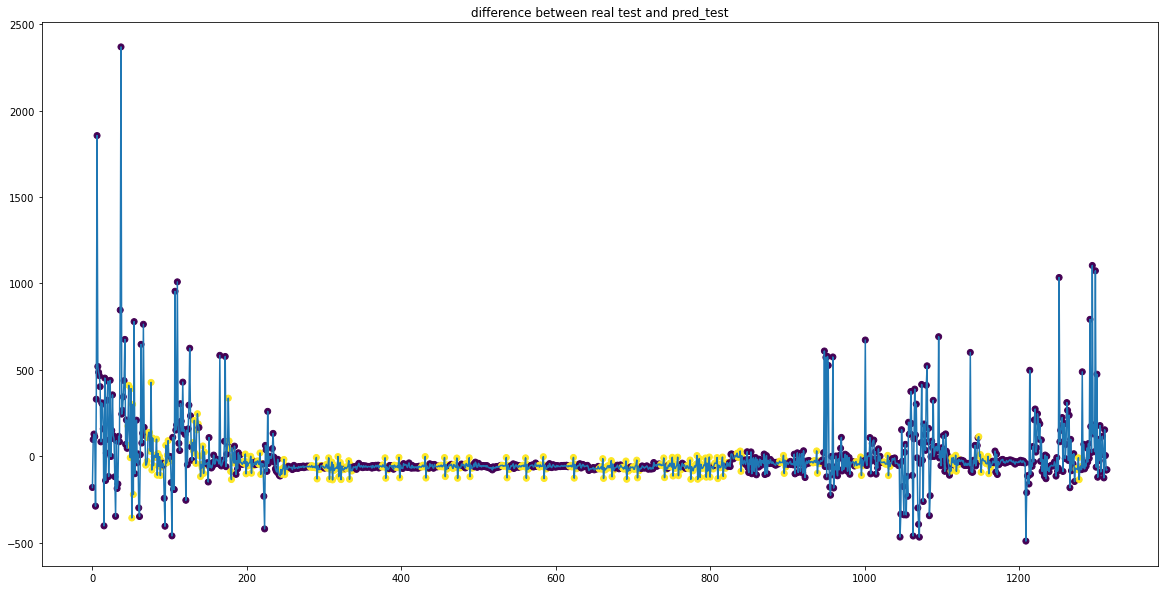

In [69]:
diff = true_test_r_r - test_predict_r_r

plt.figure(figsize=(20, 10))
plt.title('difference between real test and pred_test')
plt.plot(diff)
plt.scatter(np.arange(0, len(diff)), diff, c=test.iloc[:, -1].values)
plt.savefig('difference.png')

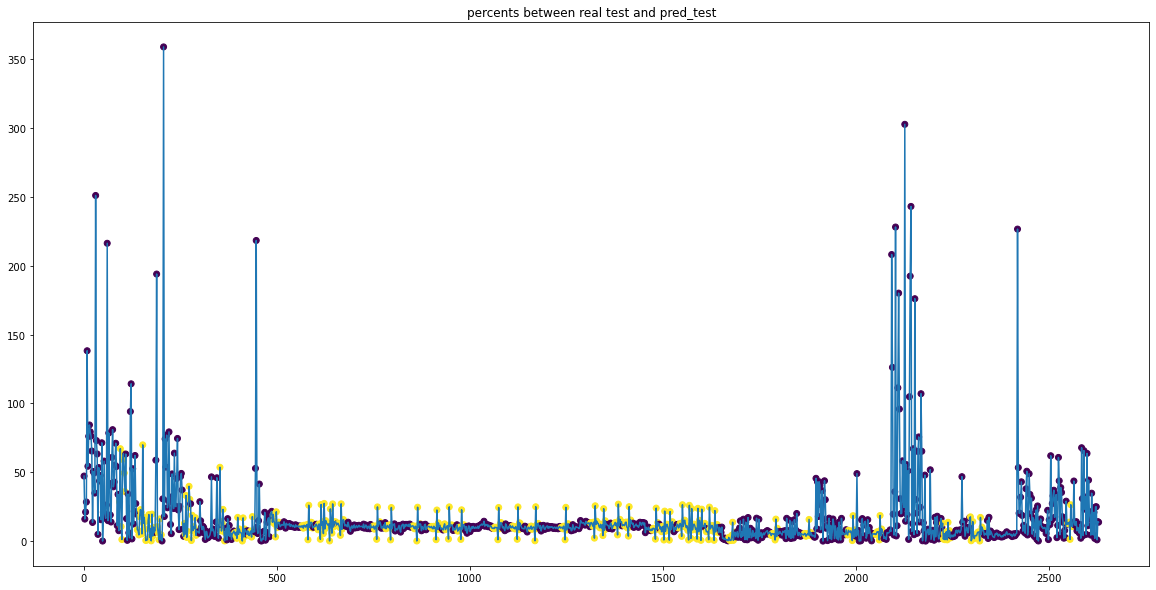

In [77]:
percents = np.divide(np.abs(diff), true_test_r_r)

plt.figure(figsize=(20, 10))
plt.title('percents between real test and pred_test')
plt.plot(np.arange(0, len(diff) * 2, 2),percents * 100)
plt.scatter(np.arange(0, len(diff) * 2, 2), percents * 100, c=test.iloc[:, -1].values)
plt.savefig('percents.png')